In [844]:
import numpy as np
np.set_printoptions(suppress=True)

In [845]:
# #Binary classification
# import matplotlib.pyplot as plt

# # random dataset

# NUM_SAMPLES_PER_CLASS = 200
# INNER_RADIUS = 2
# OUTER_RADIUS = 5
# NOISE_STD_DEV = 0.5

# theta_inner = 2 * np.pi * np.random.rand(NUM_SAMPLES_PER_CLASS)

# radius_inner = INNER_RADIUS * np.random.rand(NUM_SAMPLES_PER_CLASS) + np.random.normal(0, NOISE_STD_DEV, NUM_SAMPLES_PER_CLASS)
# x0 = radius_inner * np.cos(theta_inner)
# y0 = radius_inner * np.sin(theta_inner)
# class0_points = np.vstack([x0, y0]).T
# class0_labels = np.zeros(NUM_SAMPLES_PER_CLASS)

# theta_outer = 2 * np.pi * np.random.rand(NUM_SAMPLES_PER_CLASS)

# radius_outer = np.random.uniform(INNER_RADIUS + 1, OUTER_RADIUS, NUM_SAMPLES_PER_CLASS) + np.random.normal(0, NOISE_STD_DEV, NUM_SAMPLES_PER_CLASS)
# x1 = radius_outer * np.cos(theta_outer)
# y1 = radius_outer * np.sin(theta_outer)
# class1_points = np.vstack([x1, y1]).T
# class1_labels = np.ones(NUM_SAMPLES_PER_CLASS)


# X = np.vstack([class0_points, class1_points])
# y = np.hstack([class0_labels, class1_labels])
# y = y.reshape(-1, 1) # stupid broadcasting bug that i spent an hour on -.-


# plt.figure(figsize=(8, 6))

# plt.scatter(class0_points[:, 0], class0_points[:, 1], c='blue', label='Class 0 (Inner)', alpha=0.7)

# plt.scatter(class1_points[:, 0], class1_points[:, 1], c='red', label='Class 1 (Outer)', alpha=0.7)
# plt.title('Concentric Rings Dataset')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.legend()
# plt.grid(True)
# plt.gca().set_aspect('equal', adjustable='box')
# plt.show()

In [846]:
# Mnist dataset
import copy
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = (X_train.astype('float64') / 255.0).reshape(-1,28*28)
X_test = (X_test.astype('float64') / 255.0).reshape(-1,28*28)

X_test_copy = copy.deepcopy(X_test)
y_test_copy = copy.deepcopy(y_test)

X = X_train#[:2000,:]
y = y_train.reshape(60000, -1)#[:2000,:]
X_test = X_test#[:1000,:]
y_test = y_test.reshape(-1,1)#[:1000, :]

In [847]:
X.shape, y.shape, X_test.shape, y_test.shape

((60000, 784), (60000, 1), (10000, 784), (10000, 1))

In [848]:
def one_hot_encoding(vector):
    vector = np.array(vector).astype(int).flatten()
    # if vector.ndim == 1:
    #     return vector
    size=len(vector)
    num_classes = max(np.max(vector) + 1, 10)

    encoded_matrix = np.zeros((size, num_classes))
    encoded_matrix[np.arange(size), vector] = 1
    return encoded_matrix

In [849]:
def train_test_split(X, y, test_size=0.2):
    num_samples = X.shape[0]
    train_size = int(np.ceil(num_samples * (1-test_size)))
    test_size = int(np.floor(num_samples * test_size))

    shuffled_indices = np.arange(num_samples)
    np.random.shuffle(shuffled_indices)
    X = X[shuffled_indices]
    y= y[shuffled_indices]

    X_train = X[:train_size, :]
    y_train = y[:train_size,]
    X_test = X[train_size:]
    y_test = y[train_size:]

    return X_train, y_train, X_test, y_test

In [850]:
# X_train, y_train, X_test, y_test = train_test_split(X, y)

In [851]:
def initialize_weights_and_biases(m_inputs, layer_sizes:list):
    weights = {}
    biases = {}

    layers = [m_inputs] + layer_sizes

    for i in range(len(layers)-1):
        weights["W" + str(i+1)] = np.random.randn(layers[i], layers[i+1])# * 0.01 left out due to vanishing gradients
        biases["b" + str(i+1)] = np.zeros((1, layers[i+1]))

    # print(f"Successfully initialized weights and biases for {len(layer_sizes)} layers")
    return weights, biases


In [852]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0,z)

def softmax(z):
    exponent_values = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exponent_values / np.sum(exponent_values, axis=1, keepdims=True)

In [853]:
def forward(A, weights, biases, activation_function):
    Z_dict = {}
    A_dict = {}
    A_dict["A0"] = A
    l_dict = {}

    if activation_function == 'relu':
        activation_function = relu
    else:
        activation_function = sigmoid


    for i in range(len(weights)-1): #loop through hidden layers
        a_prev = A
        Z = np.dot(a_prev, weights["W" + str(i+1)]) + biases["b" + str(i+1)]
        Z_dict["Z" + str(i+1)] = Z
        A = activation_function(Z)
        A_dict["A" + str(i+1)] = A
        l_dict['layer' + str(i+1)] = activation_function.__name__

    last_index = len(weights)

    if weights[list(weights.keys())[-1]].shape[1] == 1:
        output_activation = sigmoid
    else:
        output_activation = softmax

    a_prev = A
    Z = np.dot(a_prev, weights["W" + str(last_index)]) + biases["b" + str(last_index)]
    Z_dict["Z" + str(last_index)] = Z
    A = output_activation(Z)
    A_dict["A" + str(last_index)] = A
    l_dict['layer' + str(last_index)] = output_activation.__name__


    cache = {"Z":Z_dict,
             "A":A_dict,
             'layer_activations':l_dict}

    # print("Successfully computed a forward pass")
    return cache

In [854]:
def calculate_loss(y_pred, y_true, loss='binary_cross_entropy'):
    epsilon = 1e-8

    if loss == 'cross_entropy':
        return - np.mean(np.sum(y_true * np.log(y_pred + epsilon), axis=1))
    else:
        return - np.mean(y_true * np.log(y_pred + epsilon) + (1-y_true)*np.log(1-y_pred + epsilon)) # added 1e-8 to avoid log(0)

In [855]:
def sigmoid_derivative(z):
    s = sigmoid(z)
    return s * (1 - s)

def relu_derivative(z):
    return (z > 0).astype(float)

In [856]:
def backpropagation(X, y, weights, biases, cache):

    activation_derivative = sigmoid_derivative

    A_cache = cache['A']
    Z_cache = cache['Z']
    L_cache = cache['layer_activations']

    Z_gradients = {}
    A_gradients = {}
    W_gradients = {}
    b_gradients = {}

    m = X.shape[0]

    for i in reversed(range(len(weights))):
        if L_cache['layer' + str(i+1)] == 'relu':
            activation_derivative = relu_derivative
        if L_cache['layer' + str(i+1)] == 'sigmoid':
            activation_derivative = sigmoid_derivative


        if i+1 == len(weights): #special case for first dZ
            dZ = A_cache["A" + str(i+1)] - y
            Z_gradients["dZ" + str(i+1)] = dZ
            W_gradients["dW" + str(i+1)] = np.dot(A_cache["A" + str(i)].T,dZ) / m
            b_gradients["db" + str(i+1)] = np.sum(dZ, axis=0, keepdims=True) / m
        else:
            dZ = np.dot(Z_gradients["dZ" + str(i+2)], weights["W" + str(i+2)].T ) * activation_derivative(Z_cache["Z" + str(i+1)])
            Z_gradients["dZ" + str(i+1)] = dZ
            W_gradients["dW" + str(i+1)] = np.dot(A_cache["A" + str(i)].T,dZ) / m
            b_gradients["db" + str(i+1)] = np.sum(dZ, axis=0, keepdims=True) / m

        # print(f"Layer {i+1} dW magnitude: {np.linalg.norm(W_gradients['dW' + str(i+1)])}")
        # print(f"Layer {i+1} db magnitude: {np.linalg.norm(b_gradients['db' + str(i+1)])}")

    grads = {"dW" : W_gradients,
             "db" : b_gradients}

    return grads

In [857]:
velocity_weights = {}
velocity_biases = {}
for i in range(len(weights)):
    velocity_weights['v' + str(i+1)] = np.zeros_like(weights['W' + str(i+1)])
    velocity_biases['b' + str(i+1)] = np.zeros_like(biases['b' + str(i+1)])


def update_params(grads, weights, biases, learning_rate, optimizer='gd', beta=0.9):

    dw = grads['dW']
    db = grads['db']

    if optimizer == 'momentum':
      for i in range(len(weights)):
        velocity_weights['v' + str(i+1)] = beta * velocity_weights['v' + str(i+1)] + ((1-beta) * dw['dW' + str(i+1)])
        weights["W" + str(i+1)] = weights["W" + str(i+1)] - learning_rate * velocity_weights['v' + str(i+1)]

        velocity_biases['b' + str(i+1)] = beta * velocity_biases['b' + str(i+1)] + ((1-beta) * db["db" + str(i+1)])
        biases["b" + str(i+1)] = biases["b" + str(i+1)] - learning_rate * velocity_biases['b' + str(i+1)]

    else:
        for i in range(len(weights)):
            weights["W" + str(i+1)] = weights["W" + str(i+1)] - learning_rate * dw["dW" + str(i+1)]
            biases["b" + str(i+1)] = biases["b" + str(i+1)] - learning_rate * db["db" + str(i+1)]

    # print("Successfully updated params")
    return weights, biases

In [858]:
def predict(X, weights, biases):
    cache = forward(X, weights, biases, activation_function='relu')
    prediction = cache['A'][list(cache['A'].keys())[-1]]
    return prediction

In [859]:
weights, biases = initialize_weights_and_biases(m_inputs=784, layer_sizes=[256, 10])

In [860]:
if len(np.unique(y)) > 2:
    y = one_hot_encoding(y)
    y_test = one_hot_encoding(y_test)
    classification_type = 'multi'
else:
    classification_type = 'single'


def accuracy(prediction, labels):
    total = len(labels)

    if classification_type == 'single':
        acc = np.sum((prediction > 0.5).astype(int) == labels) / total
    else:
        predicted_class = np.argmax(prediction, axis=1)
        true_class = np.argmax(labels, axis=1)
        acc = np.mean(predicted_class == true_class)
    return acc


In [861]:
def run(epochs, learning_rate, optimizer='gd'):
    for i in range(epochs):
        cache = forward(X, weights, biases, activation_function='relu')
        prediction = cache['A'][list(cache['A'].keys())[-1]]
        grads = backpropagation(X, y, weights, biases, cache)


        if i % 100 == 0:
            dev_predictions = predict(X_test, weights, biases)
            print(f"epoch: {i}, loss= {calculate_loss(prediction, y, loss='cross_entropy' if classification_type=='multi' else 'binary_cross_entropy')}, training-set accuracy= {accuracy(prediction, y)}, dev-set accuracy= {accuracy(dev_predictions, y_test)}")

        update_params(grads, weights, biases, learning_rate, optimizer=optimizer)

In [862]:
def run_mini_batches(epochs, learning_rate, mini_batch_size=64, optimizer='gd'):
    num_samples = X.shape[0]
    div = int(num_samples / mini_batch_size)

    divisible_by_mini_batch_size = mini_batch_size * div
    not_divisible = num_samples - divisible_by_mini_batch_size

    for epoch in range(epochs):
        shuffled_indices = np.arange(num_samples)
        np.random.shuffle(shuffled_indices)
        X_shuffled = X[shuffled_indices]
        y_shuffled = y[shuffled_indices]

        start = 0
        end = 0
        for batch in range(start, divisible_by_mini_batch_size, mini_batch_size):
            start = end
            end = start + mini_batch_size
            X_batch = X_shuffled[start:end, :]
            y_batch = y_shuffled[start:end]
            #forward
            cache = forward(X_batch, weights, biases, activation_function='relu')
            prediction = cache['A'][list(cache['A'].keys())[-1]]
            #backward
            grads = backpropagation(X_batch, y_batch, weights, biases, cache)
            #update
            update_params(grads, weights, biases, learning_rate, optimizer=optimizer)

        if not_divisible != 0:
            X_batch = X_shuffled[divisible_by_mini_batch_size:, :]
            y_batch = y_shuffled[divisible_by_mini_batch_size:]
            #forward
            cache = forward(X_batch, weights, biases, activation_function='relu')
            prediction = cache['A'][list(cache['A'].keys())[-1]]
            #backward
            grads = backpropagation(X_batch, y_batch, weights, biases, cache)
            #update
            update_params(grads, weights, biases, learning_rate, optimizer=optimizer)

        cache = forward(X, weights, biases, activation_function='relu')
        full_prediction = cache['A'][list(cache['A'].keys())[-1]]
        dev_predictions = predict(X_test, weights, biases)
        print(f"epoch: {epoch+1}, loss= {calculate_loss(full_prediction, y, loss='cross_entropy' if classification_type=='multi' else 'binary_cross_entropy')}, training-set accuracy= {accuracy(full_prediction, y)}, dev-set accuracy= {accuracy(dev_predictions, y_test)}")


In [863]:
# run(epochs=10000, learning_rate=0.005)

In [864]:
run_mini_batches(epochs=20, learning_rate=0.05, mini_batch_size=32, optimizer='momentum')

epoch: 1, loss= 1.035330882967899, training-set accuracy= 0.9158166666666666, dev-set accuracy= 0.9109
epoch: 2, loss= 0.6661698409844272, training-set accuracy= 0.9374333333333333, dev-set accuracy= 0.9255
epoch: 3, loss= 0.4828672318104737, training-set accuracy= 0.9478333333333333, dev-set accuracy= 0.9324
epoch: 4, loss= 0.38496995226333425, training-set accuracy= 0.9534333333333334, dev-set accuracy= 0.9389
epoch: 5, loss= 0.2880515586865234, training-set accuracy= 0.96105, dev-set accuracy= 0.9424
epoch: 6, loss= 0.27026227568232863, training-set accuracy= 0.96095, dev-set accuracy= 0.9398
epoch: 7, loss= 0.23415549104433117, training-set accuracy= 0.96385, dev-set accuracy= 0.9398
epoch: 8, loss= 0.1781217278431039, training-set accuracy= 0.9713166666666667, dev-set accuracy= 0.9465
epoch: 9, loss= 0.15257955206733226, training-set accuracy= 0.97405, dev-set accuracy= 0.9475
epoch: 10, loss= 0.1351891575736745, training-set accuracy= 0.97585, dev-set accuracy= 0.9456
epoch: 11, 

In [865]:
# np.savez('best_trained_model_params[32,16,10].npz', **weights, **biases)
# data = np.load('trained_model_params.npz')

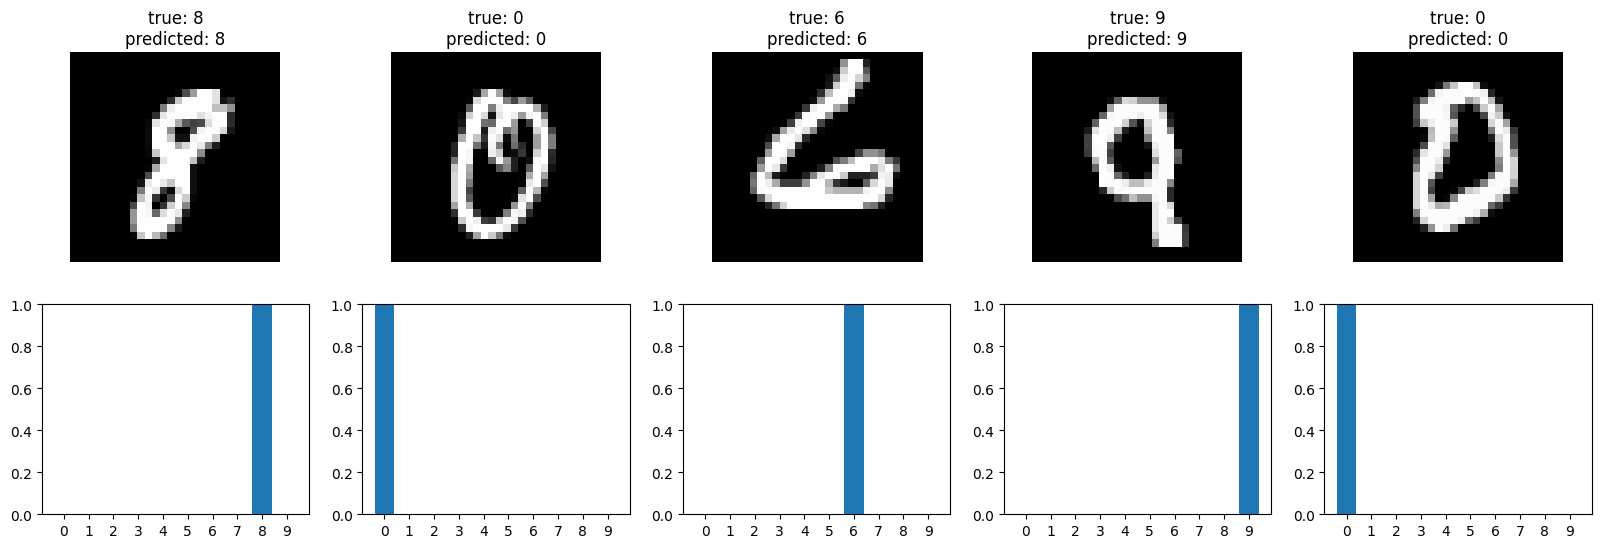

In [866]:
#visualize mnist
import matplotlib.pyplot as plt

def plot_predictions(X, y, num_images=10):
    num_samples = X.shape[0]
    shuffled_indices = np.arange(num_samples)
    np.random.shuffle(shuffled_indices)
    X_shuffled = X[shuffled_indices]
    y_shuffled = y[shuffled_indices]

    random_picks = np.random.choice(np.arange(num_samples), size=num_images)

    images = X_shuffled[random_picks]
    labels = y_shuffled[random_picks]
    predictions_probability_distribution = predict(images, weights, biases)
    predicted_labels = np.argmax(predictions_probability_distribution, axis=1)


    fig, axes = plt.subplots(2, num_images, figsize=(20,6))
    for i in range(len(images)):
        axes[0,i].imshow(images[i].reshape(28,28), cmap='gray')
        axes[0,i].set_title("true: " + str(labels[i]) + "\npredicted: " + str(predicted_labels[i]))
        axes[0,i].axis('off')
        axes[1,i].bar(x=np.arange(10), height=predictions_probability_distribution[i])
        axes[1,i].set_ylim(0,1)
        axes[1,i].set_xticks(np.arange(10))

plot_predictions(X_test_copy, y_test_copy, num_images=5)

In [867]:
# import numpy as np
# import matplotlib.pyplot as plt

# h = 0.05
# x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
# y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1

# xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
#                      np.arange(y_min, y_max, h))

# grid_points = np.c_[xx.ravel(), yy.ravel()]

# preds = predict(grid_points, weights, biases)

# Z = (preds > 0.5).astype(int)
# Z = Z.reshape(xx.shape)


# plt.figure(figsize=(8,6))
# plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu)

# plt.scatter(class0_points[:, 0], class0_points[:, 1], c='blue', label='Class 0 (Inner)', alpha=0.7)
# plt.scatter(class1_points[:, 0], class1_points[:, 1], c='red', label='Class 1 (Outer)', alpha=0.7)

# plt.title("Decision Boundary")
# plt.xlabel("Feature 1")
# plt.ylabel("Feature 2")
# plt.legend()
# plt.grid(True)
# plt.gca().set_aspect('equal', adjustable='box')
# plt.show()
